In [6]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [7]:
# File Directory for both the train and test
train_path = "input/chest-ctscan-images/Data/train"
val_path = "input/chest-ctscan-images/Data/valid"
test_path = "input/chest-ctscan-images/Data/test"

In [12]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;
    
train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155} 

 {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'normal': 13, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15} 

 {'adenocarcinoma': 120, 'large.cell.carcinoma': 51, 'normal': 54, 'squamous.cell.carcinoma': 90}


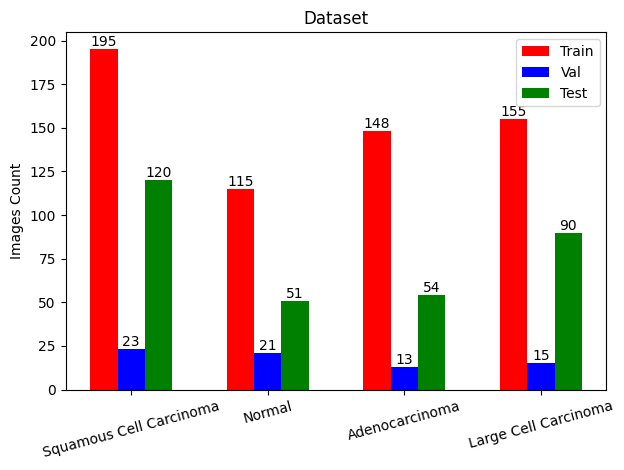

In [13]:
labels = ['Squamous Cell Carcinoma', 'Normal', 'Adenocarcinoma', 'Large Cell Carcinoma']
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train',color = 'red')
rects2 = ax.bar(x, val_list, width, label='Val', color = 'blue')
rects3 = ax.bar(x + width, test_list, width, label='Test', color = 'green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=15)
ax.legend()

ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

fig.tight_layout()

plt.show()

## Importing Keras for Image Classification

In [14]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout

In [15]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.


In [16]:
train_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [17]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 72 images belonging to 4 classes.


In [18]:
val_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [19]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 315 images belonging to 4 classes.


In [20]:
test_data.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

# Resnet 50 Model

In [21]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(350, 350,3),
                      include_top=False, weights="imagenet", 
                      pooling='max')

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(Dense(4, activation='sigmoid'))

In [16]:
model_resnet.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy'])

In [17]:
# Adding Model check point Callback

mc = ModelCheckpoint(
    filepath="./ct_resnet_best_model.hdf5",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [mc];

In [18]:
# Fitting the Model
resnet = model_resnet.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 32, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/32
122/122 [==============================] - ETA: 0s - loss: 1.5798 - accuracy: 0.3125
Epoch 1: val_accuracy improved from -inf to 0.37143, saving model to .\ct_resnet_best_model.hdf5
122/122 [==============================] - 81s 644ms/step - loss: 1.5798 - accuracy: 0.3125 - val_loss: 1.2952 - val_accuracy: 0.3714
Epoch 2/32
122/122 [==============================] - ETA: 0s - loss: 1.3049 - accuracy: 0.3734
Epoch 2: val_accuracy improved from 0.37143 to 0.45714, saving model to .\ct_resnet_best_model.hdf5
122/122 [==============================] - 81s 660ms/step - loss: 1.3049 - accuracy: 0.3734 - val_loss: 1.1866 - val_accuracy: 0.4571
Epoch 3/32
122/122 [==============================] - ETA: 0s - loss: 1.2240 - accuracy: 0.4408
Epoch 3: val_accuracy improved from 0.45714 to 0.50000, saving model to .\ct_resnet_best_model.hdf5
122/122 [==============================] - 81s 661ms/step - loss: 1.2240 - accuracy: 0.4408 - val_loss: 1.1795 - val_accuracy: 0.5000
Epoch 4/32
12

KeyboardInterrupt: 

In [20]:
# Loading the Best Fit Model 
model = load_model("./ct_resnet_best_model.hdf5")

# Incep

In [22]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (350, 350, 3), 
                         include_top = False, 
                         weights = 'imagenet')


for layer in base_model.layers:
    layer.trainable = False


x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 4 node for classification output
x = layers.Dense(4, activation='sigmoid')(x)

model_incep = tf.keras.models.Model(base_model.input, x)

model_incep.compile(optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'])

In [22]:
mc1 = ModelCheckpoint(
    filepath="./ct_incep_best_model.hdf5",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [mc1];

In [24]:
# Fitting the Model
incep = model_incep.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/20
122/122 [==============================] - ETA: 0s - loss: 2.3565 - accuracy: 0.5740
Epoch 1: val_accuracy improved from 0.54286 to 0.57143, saving model to .\ct_incep_best_model.hdf5
122/122 [==============================] - 162s 1s/step - loss: 2.3565 - accuracy: 0.5740 - val_loss: 1.7620 - val_accuracy: 0.5714
Epoch 2/20
122/122 [==============================] - ETA: 0s - loss: 1.4353 - accuracy: 0.5855
Epoch 2: val_accuracy improved from 0.57143 to 0.62857, saving model to .\ct_incep_best_model.hdf5
122/122 [==============================] - 168s 1s/step - loss: 1.4353 - accuracy: 0.5855 - val_loss: 0.7244 - val_accuracy: 0.6286
Epoch 3/20
122/122 [==============================] - ETA: 0s - loss: 1.0804 - accuracy: 0.6201
Epoch 3: val_accuracy did not improve from 0.62857
122/122 [==============================] - 162s 1s/step - loss: 1.0804 - accuracy: 0.6201 - val_loss: 1.0017 - val_accuracy: 0.6143
Epoch 4/20
122/122 [==============================] - ETA: 0s - los

In [23]:
# Loading the Best Fit Model 
model_incep = load_model("./ct_incep_best_model.hdf5")

In [26]:
test_score = model_incep.evaluate_generator(generator= test_data) 
test_score_resnet = model.evaluate_generator(generator= test_data) 

In [27]:
# Checking the Accuracy of the Model Resnet50
accuracy_resnet = model.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of the model is = {accuracy_resnet*100} %")
loss_resnet = test_score[0]
print(f"The loss of the model is = {loss_resnet} %")

The accuracy of the model is = 46.984127163887024 %
The loss of the model is = 0.7507430911064148 %


In [28]:
# Checking the Accuracy of the Incep
accuracy_incep = model_incep.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of the model is = {accuracy_incep*100} %")
loss_incep = test_score[0]
print(f"The loss of the model is = {loss_incep} %")

The accuracy of the model is = 73.65079522132874 %
The loss of the model is = 0.7507430911064148 %


In [29]:
incep.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

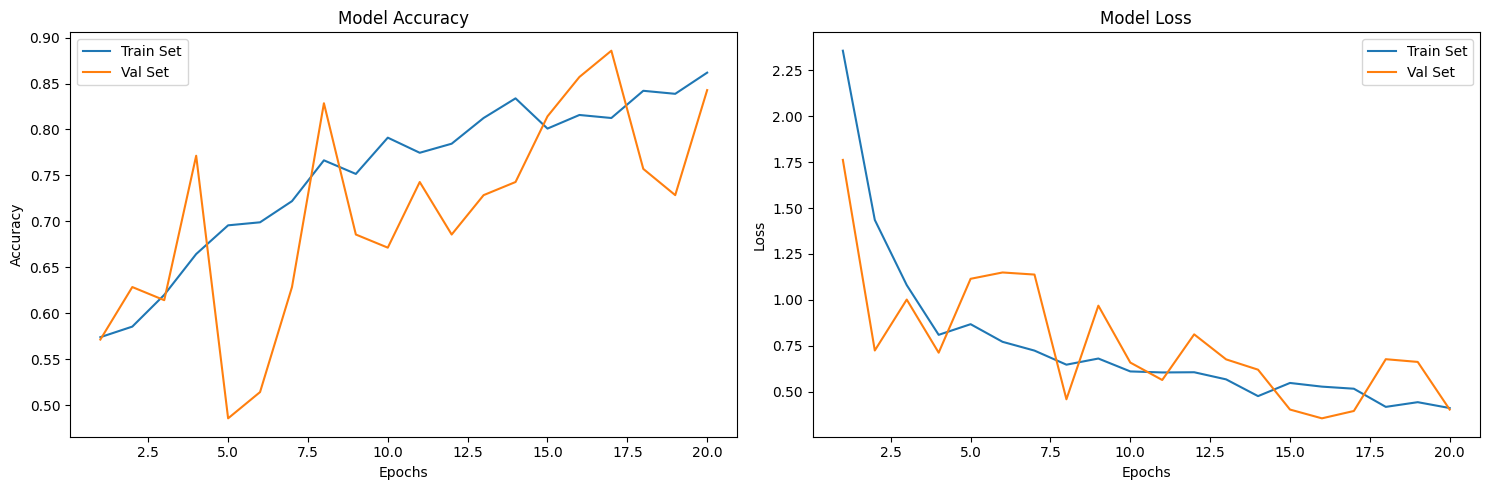

In [30]:
# Plot model performance
acc = incep.history['accuracy']
val_acc = incep.history['val_accuracy']
loss = incep.history['loss']
val_loss = incep.history['val_loss']
epochs_range = range(1, len(incep.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

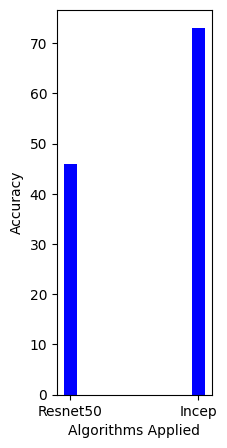

In [31]:
algos = ['Resnet50','Incep']
accuracy = [accuracy_resnet, accuracy_incep]
accuracy = np.floor([i * 100 for i in accuracy])
  
fig = plt.figure(figsize = (2, 5))
#fig.set_figwidth(4)
 
# creating the bar plot
plt.bar(algos, accuracy, color ='blue', width = 0.1)
 
plt.xlabel("Algorithms Applied")
plt.ylabel("Accuracy")
plt.show()

## Confusion Matrix

Confusion Matrix
Normalized confusion matrix
Classification Report
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.39      0.12      0.18       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.05      0.02      0.03        51
                                          normal       0.22      0.26      0.24        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.30      0.64      0.41        90

                                        accuracy                           0.28       315
                                       macro avg       0.24      0.26      0.21       315
                                    weighted avg       0.28      0.28      0.23       315



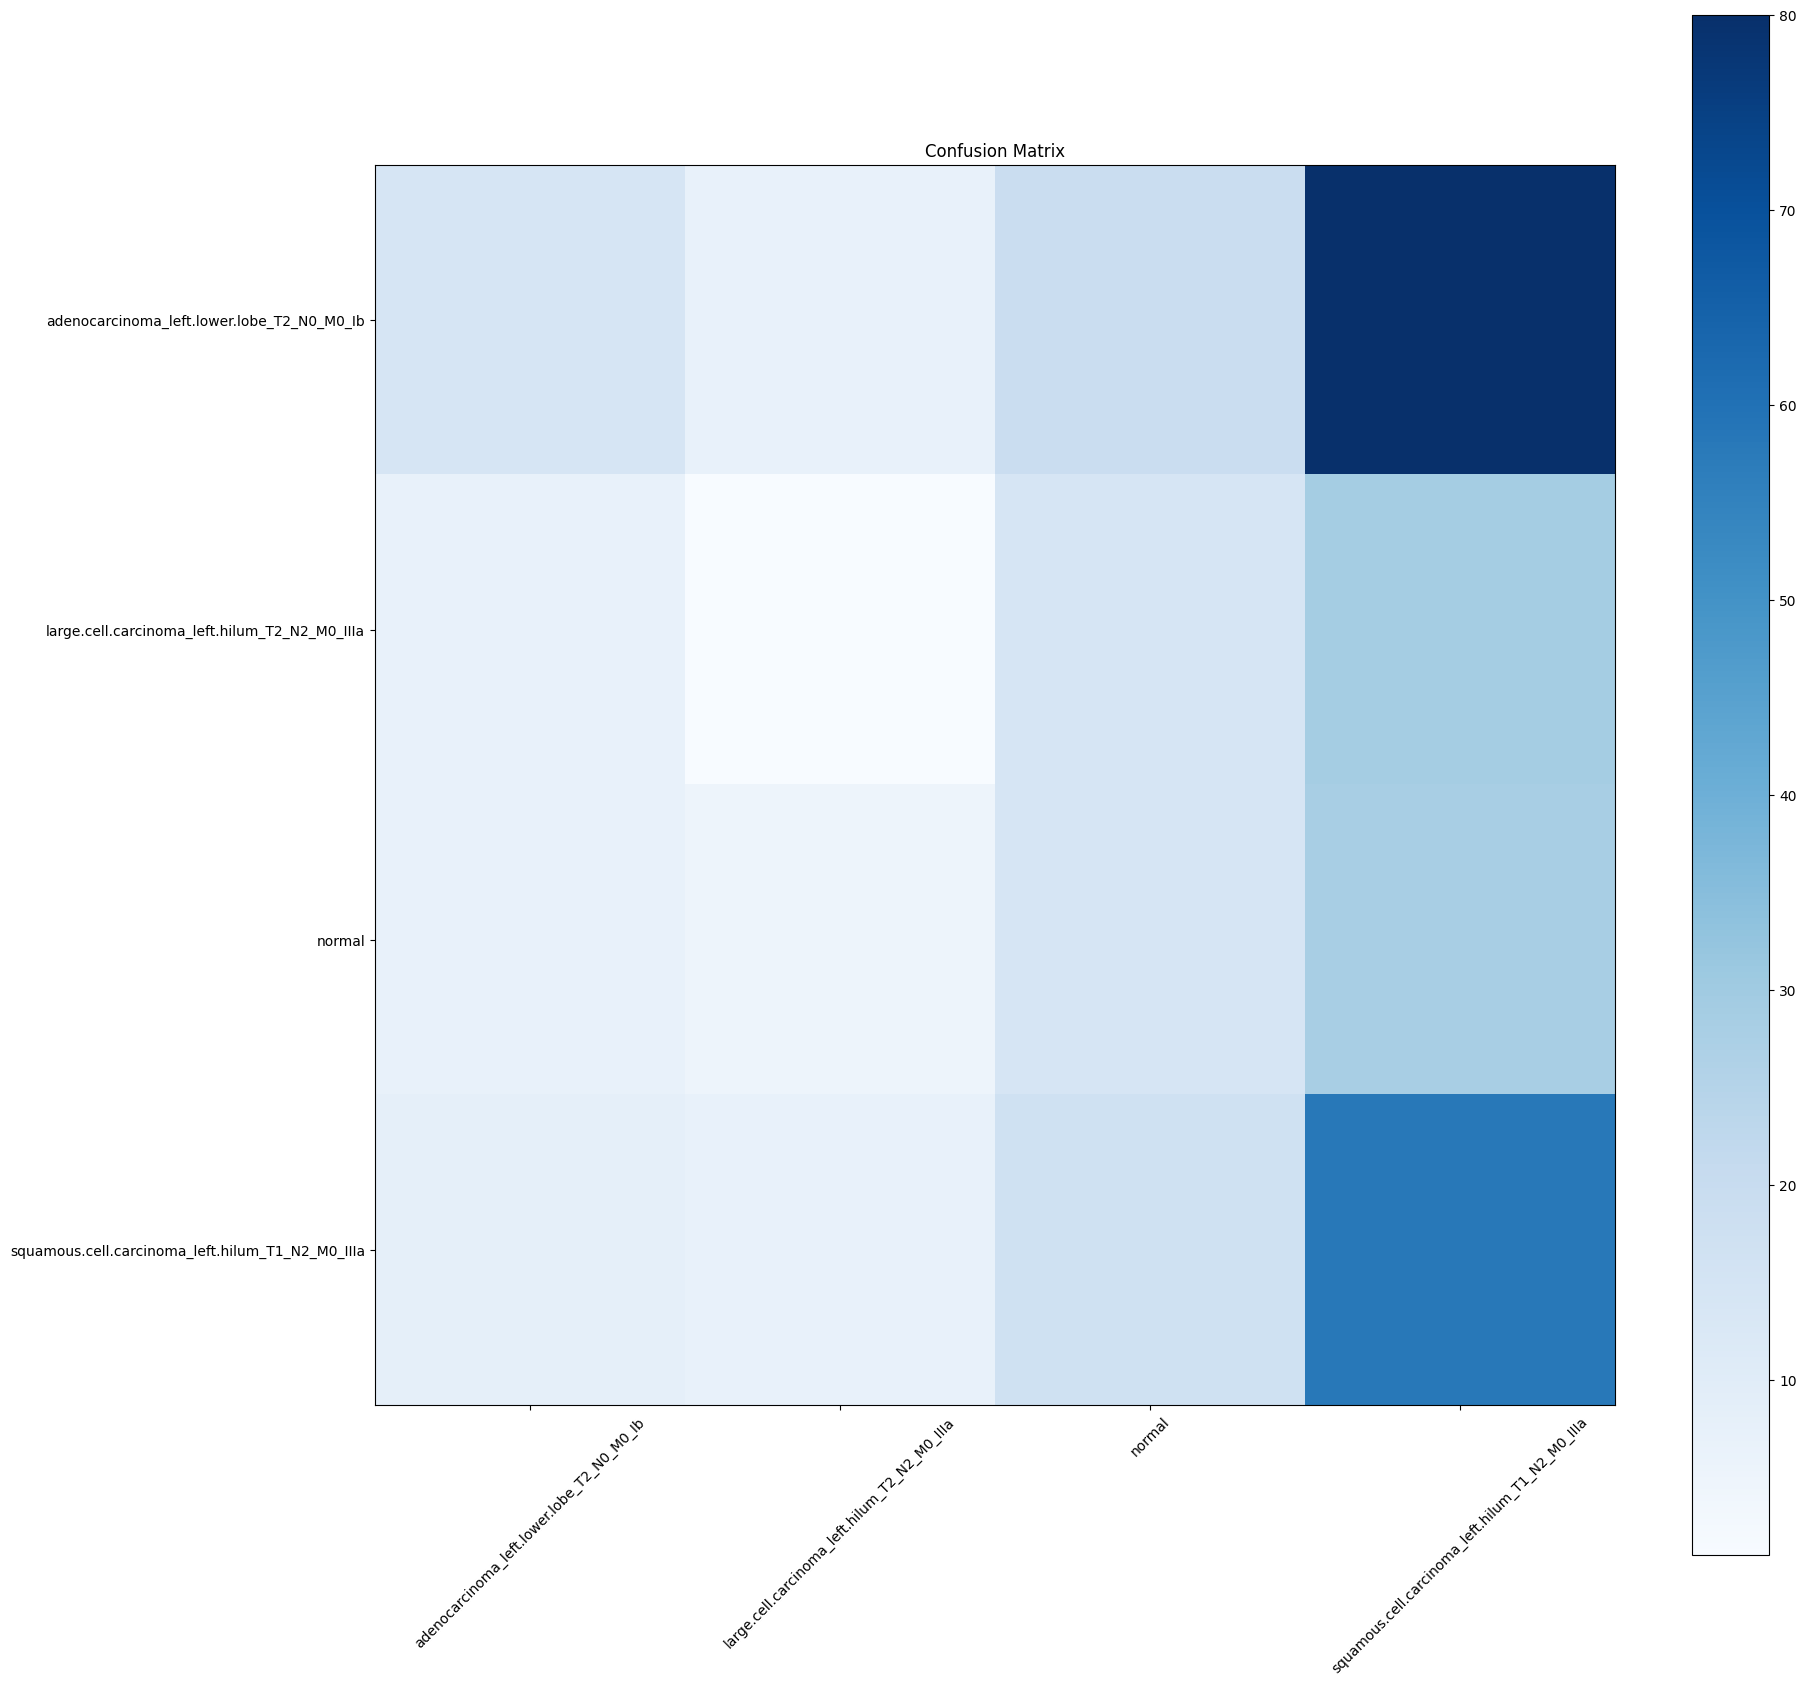

In [32]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False
target_names = []
for key in train_data.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model.predict_generator(test_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_data.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(test_data.classes, y_pred, target_names=target_names))

## Predictions

In [8]:
def chestScanPrediction(path, _model):
    classes_dir = ["Adenocarcinoma","Large cell carcinoma","Normal","Squamous cell carcinoma"]
    # Loading Image
    img = image.load_img(path, target_size=(350,350))
    # Normalizing Image
    norm_img = image.img_to_array(img)/250
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    # Getting Predictions
    pred = np.argmax(_model.predict(input_arr_img))
    # Printing Model Prediction
    print(classes_dir[pred])

In [26]:
path = "input/chest-ctscan-images/Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000108 (7).png"
chestScanPrediction(path,model_incep)

1/1 [==============================] - 0s 241ms/step
Adenocarcinoma
